# 4. Pre-Processing and Training Data

In [1]:
#Import required modules
import os
import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import matplotlib.dates as mdates

from pathlib import Path

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

## Read Data

In [2]:
# Change directory one step back and save as the root directory
ROOT_DIR = os.path.normpath(os.getcwd() + os.sep + os.pardir)
print(ROOT_DIR)

D:\gitProjects\springboard_capstone_1\Springboard_Capstone_01


In [3]:
#Define file name and location
dataset_csv = 'step3_eda_wti_price.csv'
path = '\\data\\interim\\'
f = ROOT_DIR + path + dataset_csv
print(f)

D:\gitProjects\springboard_capstone_1\Springboard_Capstone_01\data\interim\step3_eda_wti_price.csv


In [4]:
#cast csv to dataframe
df = pd.read_csv(f)

#convert 'Date' column to date format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors="raise")

#set Date as index
df.set_index('Date', drop=True, inplace=True)

#print shape of dataframe
print('Shape:',df.shape)

#display df head
display(df.head(7).round(2).T)

Shape: (269, 30)


Date,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01,2000-08-01
wti_price,29.37,29.84,25.72,28.79,31.82,29.70,31.26
oil_production_opec,26.68,26.61,27.52,28.05,27.64,27.91,28.88
oil_production_nonopec,46.82,46.94,46.62,46.62,46.78,47.05,46.93
oil_production_world,74470.54,74439.05,75116.13,75639.56,75360.22,75983.05,76857.51
henry_hub_ng_price,2.66,2.79,3.04,3.59,4.29,3.99,4.43
oil_production_us,5.85,5.92,5.85,5.85,5.82,5.74,5.79
petrol_consumption_oecd,50.23,49.36,46.29,47.34,47.96,47.25,49.83
petrol_consumption_nonoecd,28.77,28.53,28.13,28.22,28.27,28.54,28.70
us_cpi,1.70,1.71,1.71,1.71,1.72,1.73,1.73
us_ppi,1.30,1.31,1.31,1.32,1.32,1.33,1.34


## Train/Test Split

In [5]:
#expected 70-30 split sizes
print(round(len(df) * 0.7, 0))
print(round(len(df) * 0.3, 0))

188.0
81.0


In [11]:
#split data to 70$ train and 30% test sets
#... = train_test_split(X, y, test_size, random_state)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='wti_price'),
                                                    df['wti_price'], test_size=0.3,
                                                    random_state=47)

In [12]:
print('(X_train, X_test):\n',X_train.shape, X_test.shape)
print('\n(y_train, y_test):\n',y_train.shape, y_test.shape)

(X_train, X_test):
 (188, 29) (81, 29)

(y_train, y_test):
 (188,) (81,)


## Initial Models

### Imputing missing feature (predictor) values
Impute missing values using scikit-learn. Learn values to impute from a train split and apply that to the test split.

In [13]:
def count_missing(df):
    ''' Count the number of missing values .isnull() in each column well as the percentages 
    Call pd.concat() to form a single table df with 'count' and '%' columns'''
    
    missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    missing.columns=['count', '%']
    missing = missing.loc[missing['count'] > 0]
    missing.sort_values(by='count', ascending = False)
    
    return missing

In [19]:
display(count_missing(X_train))

,count,%


In [21]:
display(count_missing(X_test))

,count,%


In [22]:
#No missing data

### Scale Data

In [23]:
def scale_train_test_dataframes(X_tr, X_te):
    '''This function gets a dataframe and normalized columns and return a new data frame'''
    
    #store column names
    names = X_tr.columns
    
    from sklearn.preprocessing import StandardScaler

    #Call the StandardScaler`s fit method on `X_tr` to fit the scaler
    #then use it's `transform()` method to apply the scaling to both the train and test split
    #data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively

    scaler = StandardScaler()
    
    #scale data using sklearn preprocessing module
    scaler.fit(X_tr)
    
    X_tr_scaled = scaler.transform(X_tr)
    
    X_te_scaled = scaler.transform(X_te)

    #create new df using scaled data
    X_tr_scaled_df = pd.DataFrame(X_tr_scaled, columns=names)
    X_te_scaled_df = pd.DataFrame(X_te_scaled, columns=names)

    #set index
    X_tr_scaled_df.set_index(X_tr.index, drop=True, inplace=True)
    X_te_scaled_df.set_index(X_te.index, drop=True, inplace=True)

    #return scaled dataframe
    return X_tr_scaled_df, X_te_scaled_df

In [24]:
X_tr_scaled, X_te_scaled = scale_train_test_dataframes(X_tr, X_te)

#### Plot scaled data

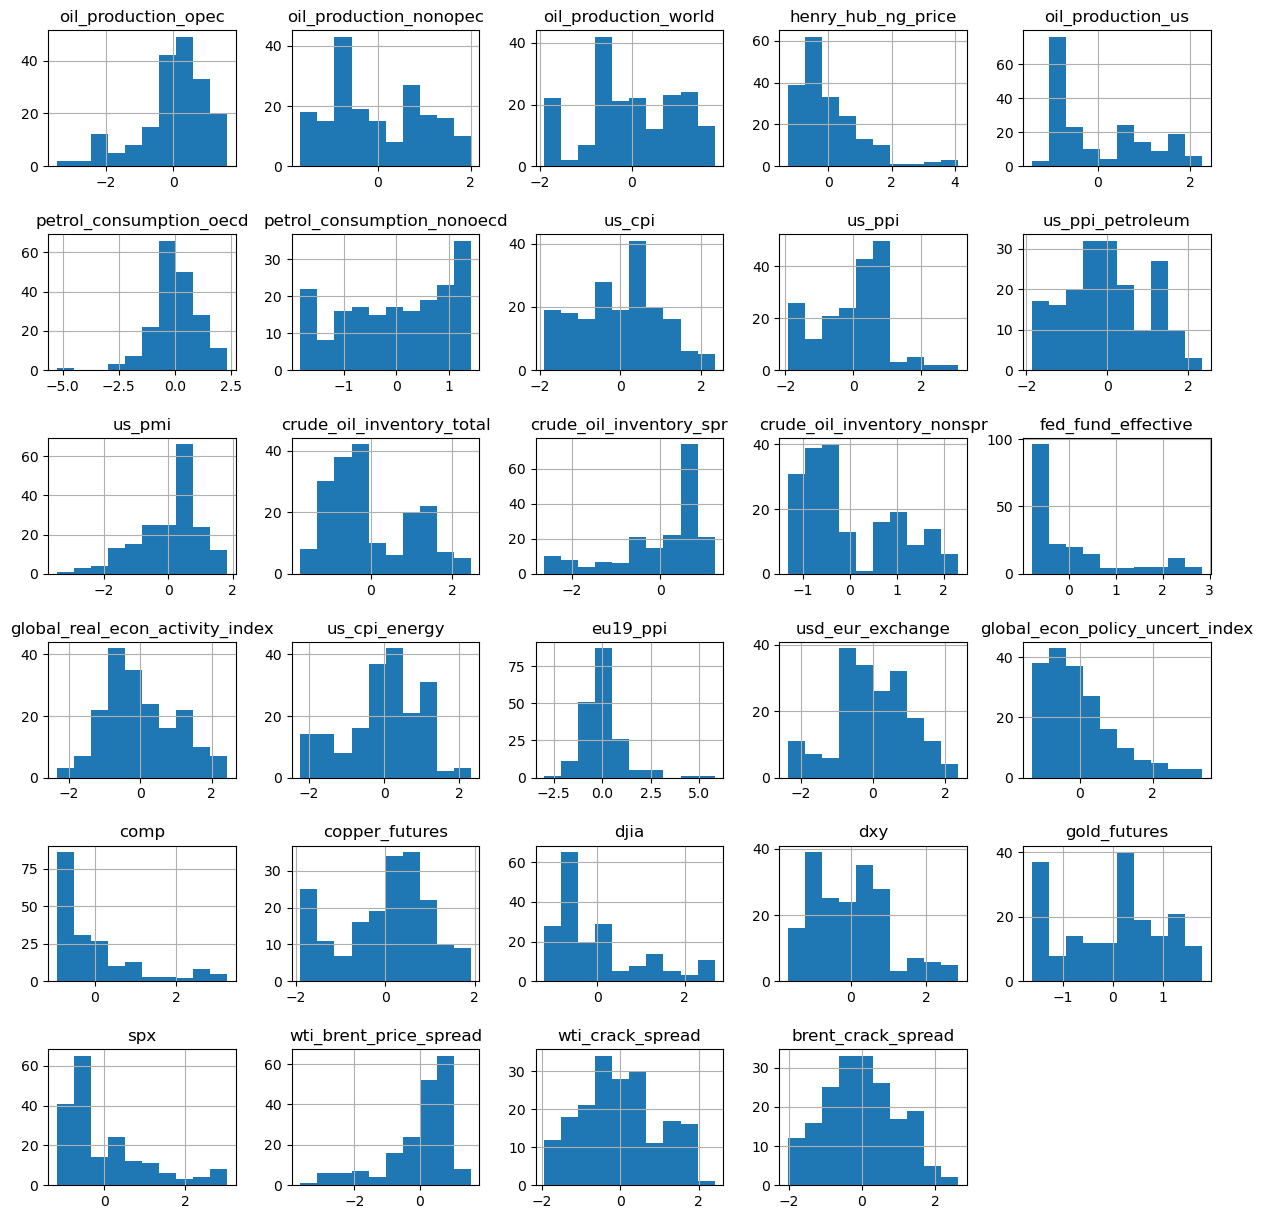

In [25]:
#Plot histogram of all  features
#Call plt.subplots_adjust() with an argument hspace=0.5 to adjust the spacing
#It's important you create legible and easy-to-read plots
X_tr_scaled.hist(figsize=(15,15))
plt.subplots_adjust(hspace=0.5);

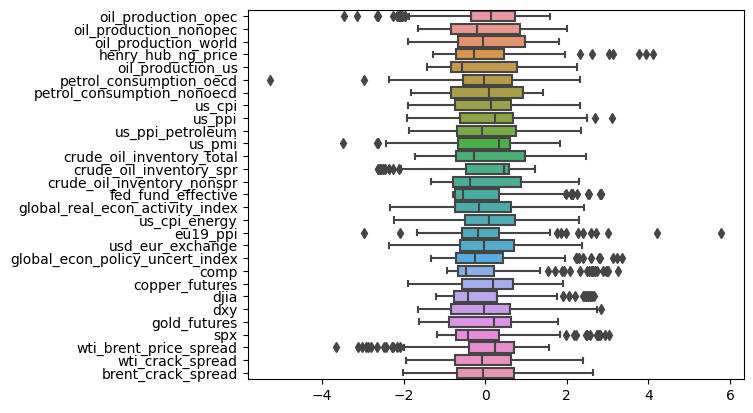

In [27]:
sns.boxplot(data = X_tr_scaled, orient = 'h')
plt.show()

## Conduct Regression Model in PyCaret

### Setup the session

In [29]:
from pycaret.regression import *

#Setup Pycaret Regression session
#Transform dataset, normalize and split the dataset.
#Log experiments and plots for experiments to be viewed later with MLflow. 

reg_model = setup(data=df, 
                target='wti_price',
                session_id=786,
                transformation=True,
                normalize=True,
                train_size=0.7,
                log_plots=True)

,Description,Value
0,Session id,786
1,Target,wti_price
2,Target type,Regression
3,Data shape,"(269, 30)"
4,Train data shape,"(188, 30)"
5,Test data shape,"(81, 30)"
6,Numeric features,29
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


### Compare models

In [30]:
# Use compare_models() function to compare ML models and their perfomrance on the data
# Use the default fold value from 10 to 5 for cross-validation generator

# Store the top 5 models in top5.
# We plan to use this for Stacking and Blending purposes. 

top5 = compare_models(n_select=5, sort='RMSE', fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.8645,16.1700,3.9268,0.9773,0.0677,0.0503,0.0740
lr,Linear Regression,3.4587,20.1417,4.4601,0.9722,0.0904,0.0665,1.2700
br,Bayesian Ridge,3.5335,20.7483,4.5364,0.9713,0.1001,0.0696,0.0220
gbr,Gradient Boosting Regressor,3.3424,21.7610,4.5698,0.9693,0.0775,0.0590,0.0460
huber,Huber Regressor,3.6543,21.6566,4.6310,0.9700,0.0934,0.0703,0.0280
ridge,Ridge Regression,3.6608,22.2277,4.7060,0.9692,0.1071,0.0721,0.0200
lightgbm,Light Gradient Boosting Machine,3.6997,25.5448,4.9865,0.9645,0.0859,0.0665,0.0320
rf,Random Forest Regressor,3.6481,28.3243,5.2053,0.9598,0.0842,0.0632,0.0880
xgboost,Extreme Gradient Boosting,3.8548,28.1685,5.2701,0.9609,0.0836,0.0655,0.0680
ada,AdaBoost Regressor,4.1003,28.5414,5.3380,0.9605,0.0982,0.0757,0.0460


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

### Hyper-parameterization

In [31]:
# Tune the top 5 models dynamically with a higher iteration rate (n_iter) 
# This is to find more optimal hyper parameters over a larger search space. 

tuned_top5 = [tune_model(i, n_iter=120, optimize='RMSE', fold=5) for i in top5]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.4562,22.0928,4.7003,0.9711,0.0648,0.0525
1,2.8060,12.9495,3.5985,0.9820,0.0529,0.0463
2,3.8726,30.0629,5.4830,0.9567,0.1221,0.0809
3,2.3979,9.9085,3.1478,0.9876,0.0573,0.0448
4,3.1704,20.8490,4.5661,0.9681,0.0736,0.0530
Mean,3.1406,19.1725,4.2991,0.9731,0.0741,0.0555
Std,0.5099,7.1342,0.8307,0.0108,0.0250,0.0131


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.1885,28.5764,5.3457,0.9626,0.0873,0.0702
1,3.1214,16.5760,4.0714,0.9770,0.0853,0.0603
2,3.1722,15.9818,3.9977,0.9770,0.0809,0.0640
3,3.4424,17.8373,4.2234,0.9777,0.1023,0.0697
4,3.3691,21.7371,4.6623,0.9668,0.0962,0.0685
Mean,3.4587,20.1417,4.4601,0.9722,0.0904,0.0665
Std,0.3839,4.6694,0.4992,0.0063,0.0078,0.0038


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.3013,27.8432,5.2767,0.9636,0.0881,0.0729
1,3.2244,17.1362,4.1396,0.9762,0.0980,0.0648
2,3.3079,18.9483,4.3530,0.9727,0.0898,0.0661
3,3.3939,17.9205,4.2333,0.9776,0.1317,0.0768
4,3.4360,21.8477,4.6742,0.9666,0.0926,0.0675
Mean,3.5327,20.7392,4.5353,0.9713,0.1000,0.0696
Std,0.3912,3.8944,0.4123,0.0054,0.0162,0.0045


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 120 candidates, totalling 600 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.7324,13.5661,3.6832,0.9822,0.0550,0.0431
1,2.5908,11.9010,3.4498,0.9835,0.0562,0.0456
2,3.5690,25.1722,5.0172,0.9637,0.1203,0.0767
3,2.5211,9.3722,3.0614,0.9883,0.0511,0.0449
4,3.2266,22.6469,4.7589,0.9654,0.0681,0.0522
Mean,2.9280,16.5317,3.9941,0.9766,0.0701,0.0525
Std,0.4044,6.2217,0.7608,0.0101,0.0257,0.0125


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 120 candidates, totalling 600 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.3512,28.6998,5.3572,0.9624,0.0882,0.0735
1,3.2809,17.7241,4.2100,0.9754,0.0861,0.0641
2,3.4922,19.8655,4.4571,0.9714,0.0849,0.0677
3,3.1791,15.8951,3.9869,0.9801,0.1040,0.0687
4,3.1928,19.6087,4.4282,0.9700,0.0942,0.0662
Mean,3.4992,20.3586,4.4879,0.9719,0.0915,0.0680
Std,0.4404,4.4101,0.4666,0.0059,0.0070,0.0031


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 120 candidates, totalling 600 fits


### Combine top 5 models

#### Build blend models

In [33]:
# Building a blending model from our top 5 models and evaluate the results. 
# Blending models is an ensemble method of combining different machine learning algorithms.
# Use a majority vote to build consensus of final prediction values.

blender_specific = blend_models(estimator_list=tuned_top5[0:], fold=5, optimize='RMSE', choose_better=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.3986,19.3494,4.3988,0.9747,0.0668,0.0545
1,2.6135,10.0973,3.1776,0.9860,0.0596,0.0485
2,3.1511,17.4189,4.1736,0.9749,0.0939,0.0643
3,2.3310,8.4218,2.9020,0.9895,0.0647,0.0476
4,2.5952,14.1445,3.7609,0.9784,0.0717,0.0496
Mean,2.8179,13.8864,3.6826,0.9807,0.0713,0.0529
Std,0.3941,4.1619,0.5700,0.0060,0.0119,0.0062


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [35]:
# Below is a view of the model parameters. 
print(blender_specific)

display(blender_specific)

VotingRegressor(estimators=[('Extra Trees Regressor',
                             ExtraTreesRegressor(n_jobs=-1, random_state=786)),
                            ('Linear Regression', LinearRegression(n_jobs=-1)),
                            ('Bayesian Ridge',
                             BayesianRidge(alpha_1=0.3, alpha_2=0.001,
                                           compute_score=True, lambda_1=0.0005,
                                           lambda_2=0.2, normalize=False)),
                            ('Gradient Boosting Regressor',
                             GradientBoostingRegressor(max_depth=8,
                                                       max_features='sqrt',
                                                       min_impurity_decrease=0.02,
                                                       min_samples_leaf=5,
                                                       min_samples_split=5,
                                                       n_estimators=220,
 

VotingRegressor(estimators=[('Extra Trees Regressor',
                             ExtraTreesRegressor(n_jobs=-1, random_state=786)),
                            ('Linear Regression', LinearRegression(n_jobs=-1)),
                            ('Bayesian Ridge',
                             BayesianRidge(alpha_1=0.3, alpha_2=0.001,
                                           compute_score=True, lambda_1=0.0005,
                                           lambda_2=0.2, normalize=False)),
                            ('Gradient Boosting Regressor',
                             GradientBoostingRegressor(max_depth=8,
                                                       max_features='sqrt',
                                                       min_impurity_decrease=0.02,
                                                       min_samples_leaf=5,
                                                       min_samples_split=5,
                                                       n_estimators=220,
                                                       random_state=786,
                                                       subsample=0.9)),
                            ('Huber Regressor',
                             HuberRegressor(alpha=0.01, epsilon=1.9))],
                n_jobs=-1)

#### Build stack models

In [36]:
# Build a stacking model from our top 5 models and evaluate the results.
# Stacking models is an ensemble method of using meta learning.
# A meta model is created using multiple base estimators to generate the final prediction.

stacker_specific = stack_models(estimator_list=tuned_top5[1:],
                                meta_model=tuned_top5[0],
                                fold=5,
                                optimize='RMSE',
                                choose_better=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.3229,19.4954,4.4154,0.9745,0.0649,0.0512
1,2.6085,11.2930,3.3605,0.9843,0.0533,0.0440
2,3.2463,19.5619,4.4229,0.9718,0.1107,0.0710
3,2.3471,9.0387,3.0064,0.9887,0.0445,0.0391
4,2.0464,8.4025,2.8987,0.9871,0.0568,0.0391
Mean,2.7142,13.5583,3.6208,0.9813,0.0660,0.0489
Std,0.4991,4.9686,0.6695,0.0068,0.0233,0.0119


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [37]:
# Below is a view of the model parameters. 
print(stacker_specific)
display(stacker_specific)

StackingRegressor(cv=5,
                  estimators=[('Linear Regression',
                               LinearRegression(n_jobs=-1)),
                              ('Bayesian Ridge',
                               BayesianRidge(alpha_1=0.3, alpha_2=0.001,
                                             compute_score=True,
                                             lambda_1=0.0005, lambda_2=0.2,
                                             normalize=False)),
                              ('Gradient Boosting Regressor',
                               GradientBoostingRegressor(max_depth=8,
                                                         max_features='sqrt',
                                                         min_impurity_decrease=0.02,
                                                         min_samples_leaf=5,
                                                         min_samples_split=5,
                                                         n_estimators=220,
           

StackingRegressor(cv=5,
                  estimators=[('Linear Regression',
                               LinearRegression(n_jobs=-1)),
                              ('Bayesian Ridge',
                               BayesianRidge(alpha_1=0.3, alpha_2=0.001,
                                             compute_score=True,
                                             lambda_1=0.0005, lambda_2=0.2,
                                             normalize=False)),
                              ('Gradient Boosting Regressor',
                               GradientBoostingRegressor(max_depth=8,
                                                         max_features='sqrt',
                                                         min_impurity_decrease=0.02,
                                                         min_samples_leaf=5,
                                                         min_samples_split=5,
                                                         n_estimators=220,
                                                         random_state=786,
                                                         subsample=0.9)),
                              ('Huber Regressor',
                               HuberRegressor(alpha=0.01, epsilon=1.9))],
                  final_estimator=ExtraTreesRegressor(n_jobs=-1,
                                                      random_state=786),
                  n_jobs=-1, passthrough=True)

### Evaluare models

#### Evaluate blend model

In [38]:
evaluate_model(blender_specific)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### Evaluate stack model

In [39]:
evaluate_model(stacker_specific)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### Evaluate the perforomances

residuals: blend vs stack


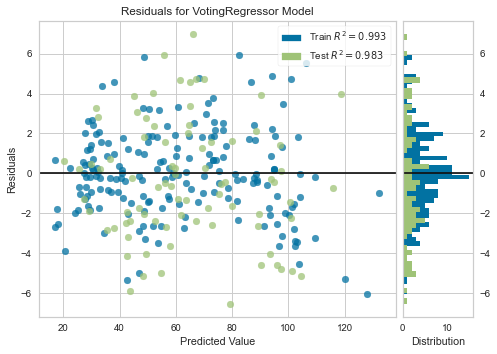

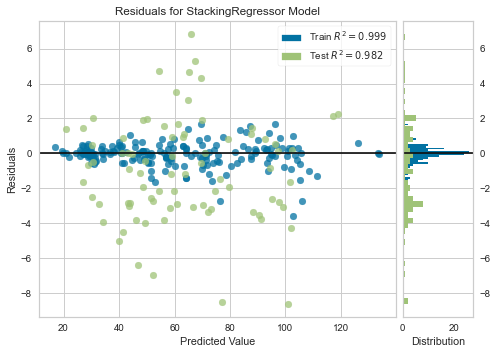

error: blend vs stack


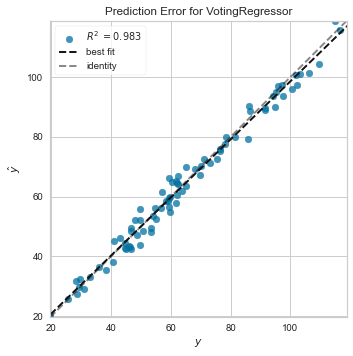

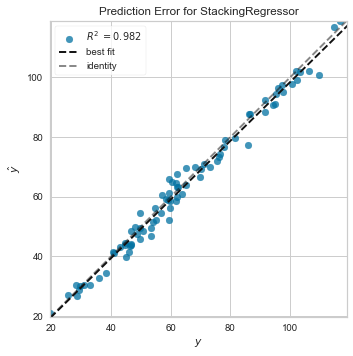

learning: blend vs stack


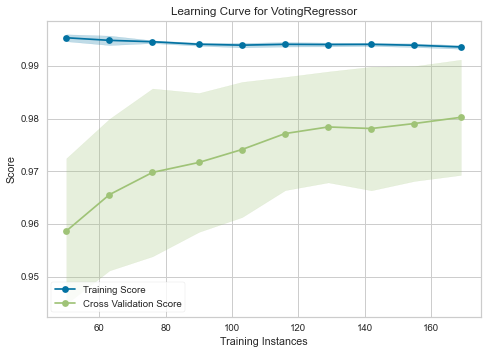

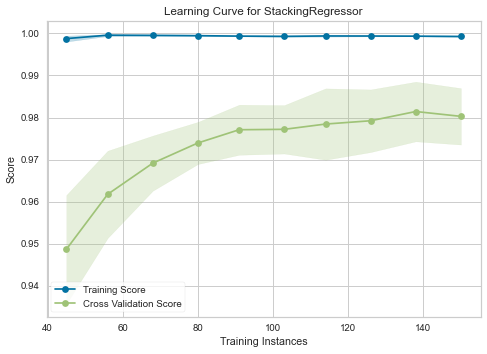

In [140]:
# Use Pycaret's built in plot_model() function to generate side-by-side plots:
# Dispaly Residuals chart, Prediction Error and Cross Validation (learning) charts.
print('residuals: blend vs stack')
plot_model(blender_specific, plot='residuals', scale=0.7)
plot_model(stacker_specific, plot='residuals', scale=0.7)

print('error: blend vs stack')
plot_model(blender_specific, plot='error', scale=0.7)
plot_model(stacker_specific, plot='error', scale=0.7)

print('learning: blend vs stack')
plot_model(blender_specific, plot='learning', scale=0.7)
plot_model(stacker_specific, plot='learning', scale=0.7)


In [141]:
# Execute the predict_model() function to use the blender model to generate the predicted values. 
pred_tunded_blender = predict_model(blender_specific)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2.4828,9.1130,3.0188,0.9830,0.0514,0.0424


In [142]:
# Execute the predict_model() function to use the stack model to generate the predicted values. 
pred_tunded_stacker = predict_model(stacker_specific)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2.4624,9.5120,3.0841,0.9823,0.0522,0.0418


In [143]:
# The stack model seems to perform better in both our train and test so let us finalize it.
#The finalize_model() function trains the model on the entire dataset. 

finalize_stacker = finalize_model(stacker_specific)
display(finalize_stacker)

Pipeline(memory=Memory(location=C:\Users\Farid\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['oil_production_opec',
                                             'oil_production_nonopec',
                                             'oil_production_world',
                                             'henry_hub_ng_price',
                                             'oil_production_us',
                                             'petrol_consumption_oecd',
                                             'petrol_consumption_nonoecd',
                                             'us_cpi', 'us_ppi',
                                             'us_ppi_petroleum', 'us_pmi',
                                             'crude_o...
                                               ('Gradient Boosting Regressor',
                                                GradientBoostingRegressor(max_depth=8,
                                                                          max_features='sqrt',
                                                                          min_impurity_decrease=0.02,
                                                                          min_samples_leaf=5,
                                                                          min_samples_split=5,
                                                                          n_estimators=220,
                                                                          random_state=786,
                                                                          subsample=0.9)),
                                               ('Huber Regressor',
                                                HuberRegressor(alpha=0.01,
                                                               epsilon=1.9))],
                                   final_estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                       random_state=786),
                                   n_jobs=-1, passthrough=True))])

## Analyze the Performance of Final Model on Entire Dataset

In [144]:
# The predict_model() can be executed with the final stack model over the entire dataset and saved to a csv file. 
pred_final_stacker = predict_model(finalize_stacker, data=df)
pred_final_stacker.to_csv('pred_final_blender.csv')
pred_final_stacker.describe().T

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.4313,0.5027,0.7090,0.9993,0.0118,0.0072


,count,mean,std,min,25%,50%,75%,max
oil_production_opec,269.0,-1.905576e-08,1.001864,-2.326967,-0.599912,-0.016951,0.713521,2.273340
oil_production_nonopec,269.0,7.046199e-08,1.001864,-1.779249,-0.779552,-0.106372,0.905974,1.738742
oil_production_world,269.0,-8.730197e-08,1.001864,-1.821037,-0.607320,-0.162478,0.991107,1.775432
henry_hub_ng_price,269.0,-1.134482e-07,1.001864,-2.273668,-0.774546,-0.013427,0.793234,2.324702
oil_production_us,269.0,-1.896713e-07,1.001864,-2.520344,-0.830803,-0.499608,0.989855,1.623040
petrol_consumption_oecd,269.0,-3.567416e-08,1.001864,-3.592307,-0.638639,-0.107287,0.613406,2.894321
petrol_consumption_nonoecd,269.0,-4.475888e-08,1.001864,-1.624602,-0.942103,0.077831,0.959801,1.552300
us_cpi,269.0,3.633889e-08,1.001864,-1.791856,-0.786777,0.105719,0.702851,2.399487
us_ppi,269.0,1.418103e-07,1.001864,-1.754019,-0.688208,0.242580,0.695360,3.120250
us_ppi_petroleum,269.0,-9.217670e-08,1.001864,-2.050526,-0.758847,0.057318,0.713346,2.775772


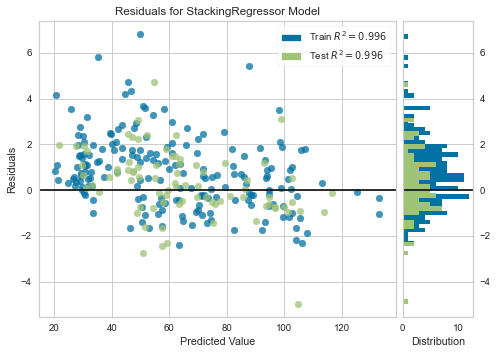

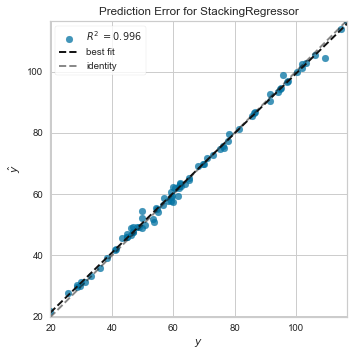

In [148]:
# Use plot_model() function to generate Residuals and Error plots for the stack model. 
plot_model(finalize_stacker, plot='residuals', scale=0.7)
plot_model(finalize_stacker, plot='error', scale=0.7)

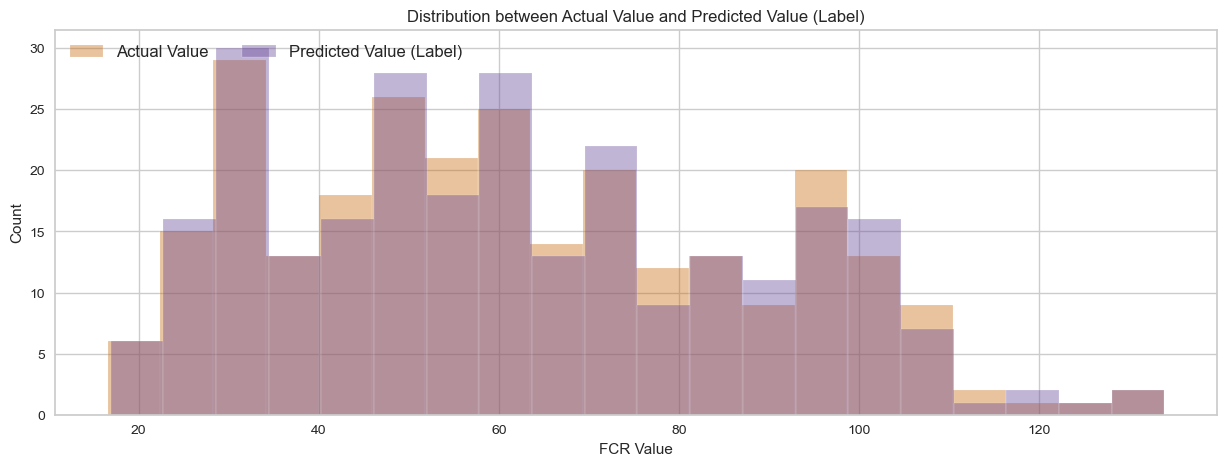

In [149]:
# An interesting view is looking at the Actual Values and Predicted Values (Label) in 
#a histogram over the entire dataset. This shows the distribution between the values.
#We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 

plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(pred_final_stacker["wti_price"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(pred_final_stacker["prediction_label"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("FCR Value")
plt.legend(('Actual Value', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)
plt.show()

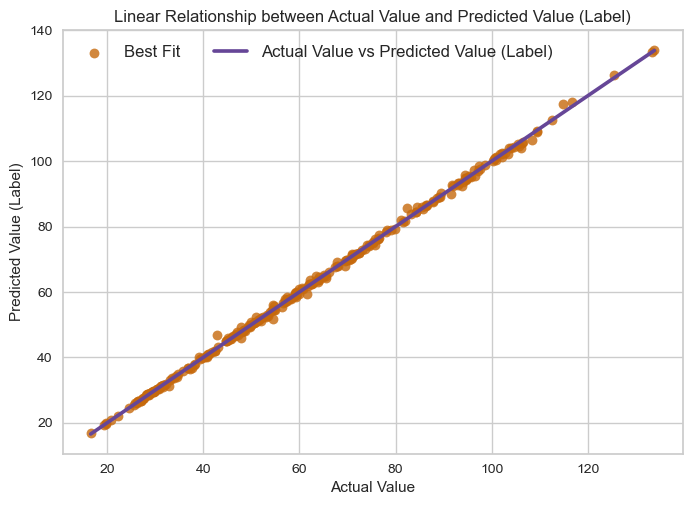

In [150]:
# We can plot the Predicted Value (Label) and Actual Value over the entire dataset. 
sns.regplot(x="wti_price", y="prediction_label",
            data=pred_final_stacker, lowess=False, 
            scatter_kws ={'s':50}, 
            line_kws={"color": "#664697"},
            color="#c6690c")

plt.title("Linear Relationship between Actual Value and Predicted Value (Label)")
plt.ylabel("Predicted Value (Label)")
plt.xlabel("Actual Value")
plt.legend(('Best Fit', 'Actual Value vs Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)
plt.show()

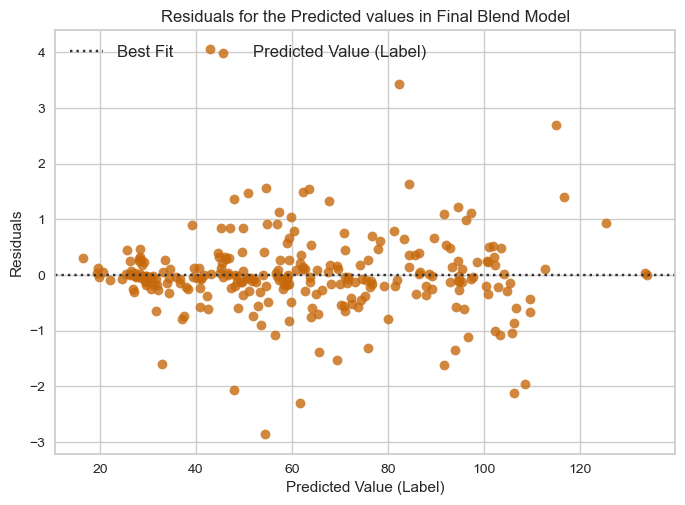

In [152]:
# We can compare the Predicted Values (Label) and Residuals in an error plot over the entire dataset. 
sns.residplot(x="wti_price", y="prediction_label",
              data=pred_final_stacker, lowess=False,
              scatter_kws ={'s':50},
              line_kws={"color": "#664697"},
              color="#c6690c")

plt.title("Residuals for the Predicted values in Final Blend Model")
plt.ylabel("Residuals")
plt.xlabel("Predicted Value (Label)")
#plt.xlim((74,101))
plt.legend(('Best Fit', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)
plt.show()